In [1]:
%pylab inline
import os
os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES'] = "0"
from tardis import *
import time
config = tf.ConfigProto()  
config.gpu_options.allow_growth=True
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.5
set_session(tf.Session(config=config))

Populating the interactive namespace from numpy and matplotlib
Tensorflow Version:  1.15.0


Using TensorFlow backend.


Running TARDIS 2.1...


In [114]:
def chi(inputs, data, inverse_covar):

    residual = tf.subtract(inputs, data)
    a = tf.sparse.sparse_dense_matmul(inverse_covar, residual,adjoint_b=True)
    value = tf.matmul(residual,a)
    return value

def overone(flux):

    flux = K.clip(flux,1,None)
    return(tf.reduce_sum(flux))

def nodes(flux):

    flux = K.clip(flux,0,0.4)
    return(tf.reduce_sum(flux))
class lya_survey:
    
    def __init__(self,uni, snr_min, snr_max, sm=1.0, alpha = 2.8,n_skewers=1000, add_ondiag_cont_err=False,uniform=False):
        self.universe = uni
        self.sm = sm
        self.n_skewers = n_skewers
        self.random = True  #not sure what this flag does?
        self.alpha = alpha
        self.add_ondiag_cont_err = add_ondiag_cont_err
        
        #power law distribution of noise with high snr cutoff
        self.snr, self.noise_level = gen_noise(uni.nc,n_skewers,snr_min,snr_max,self.alpha)
        
        self.flux_field = np.exp(-1*self.universe.final_tau_RSD)
        self.uniform = uniform
    def select_skewers(self,seed=False):
        
        #define indicies with data
        # np.random.seed(0)
        # x = np.array(np.floor(np.random.rand(self.n_skewers)*self.universe.nc),dtype=int)
        # y = np.array(np.floor(np.random.rand(self.n_skewers)*self.universe.nc),dtype=int)
        # pos = np.vstack([x,y])

        z = np.arange(0,self.universe.nc)
        
        
        if seed:
            random.seed(seed)

        skewers_pos = []
        if self.uniform:
            self.n_skewers = self.uniform**2
            x = around(linspace(0,self.universe.nc-1,self.uniform+2)[1:-1])
            y = around(linspace(0,self.universe.nc-1,self.uniform+2)[1:-1])
            
            pos = np.vstack([meshgrid(x,y)[0].flatten(),meshgrid(x,y)[1].flatten()]).T
            for i in pos:
                skewers_pos.append(np.hstack([i*np.ones((self.universe.nc,2)),z.reshape(1,-1).T]))
        else:
            random_list = list(itertools.product(range(self.universe.nc), range(self.universe.nc)))
            pos = np.array(random.sample(random_list, self.n_skewers)).T
            
            for i in pos.T:
                skewers_pos.append(np.hstack([i*np.ones((self.universe.nc,2)),z.reshape(1,-1).T]))

            
        self.skewers_fin = np.array(np.vstack(skewers_pos),dtype=int)
        
        #flux values at each point
        self.vals_lya = self.flux_field[0,self.skewers_fin[:,0],self.skewers_fin[:,1],self.skewers_fin[:,2]]

        #add noise
        n = numpy.array([numpy.random.normal(scale = np.sqrt(abs(i)), size = self.universe.nc) for i in self.noise_level]).flatten()

        if self.add_ondiag_cont_err:
            # Add estimated error from spectrum continuum fitting to noise variance matrix (but not noise realization).
            self.noise_level += continuum_fit_err(self.snr, self.universe.nc)

        noise_variance= numpy.array([abs(i)*numpy.ones(self.universe.nc) for i in self.noise_level]).flatten()
        # The inverse covar must be of type float32.
        noise_variance = noise_variance.astype(np.float32)
        indices = [(i, i) for i in range(len(noise_variance))]
        self.inverse_covar = tf.compat.v1.SparseTensorValue(indices, noise_variance**-1, [len(noise_variance), len(noise_variance)])
        
        self.vals_observed = ndimage.gaussian_filter1d(self.vals_lya,self.sm) + n

        if self.add_ondiag_cont_err:
            # Offset flux values if estimated on-diagonal continuum fitting error is added.
            # Assumes each skewer's noise_level array is constant across the skewer.
            continuum_fit_err_sigma = continuum_fit_err(self.snr, self.universe.nc)
            for i in range(0, len(self.vals_observed), self.universe.nc):
                self.vals_observed[i:i + self.universe.nc] /= (1 + np.random.normal(scale=continuum_fit_err_sigma[i // self.universe.nc][0]))



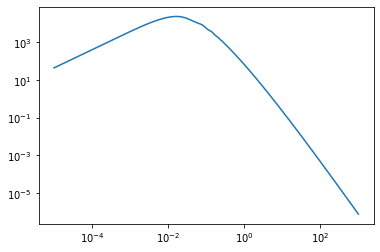

In [3]:
klin = np.loadtxt('Planck15_a1p00.txt').T[0]
plin = np.loadtxt('Planck15_a1p00.txt').T[1]
plt.loglog(klin,plin)
ipklin = iuspline(klin, plin)

In [140]:
n=128
uni = universe(bs=n, nc=n,z_f=2.0,ipklin = ipklin)
uni.evolv() #run the simulation

(128, 128, 128)
2097152 65 2097152
Total run time 19.351322889328003


In [5]:
from myfunction import*

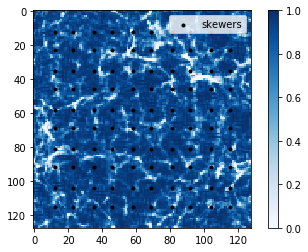

In [141]:
unif = 10
n_los = unif**2
mock_lya = lya_survey(uni,2,10,sm=1,n_skewers=n_los,uniform=unif)
mock_lya.select_skewers()
imshow(np.exp(-1*uni.final_tau_RSD[0,:,:,0]),cmap="Blues")
colorbar()
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers')
legend(loc=1)

### $$L_1  = k_1(S_m(s) - s)^2$$
### $$L_2 = k_2(R(s) - d)^\mathrm{T}N^{-1} (R(s)-d)$$
### $$L_3 = k_3\sum clip(s,1,+\infty)$$
### $$L_4 = k_4\sum clip(s,0,0.4)$$
### $$L = L_1+L_2+L_3+L_4$$

In [142]:
tf.compat.v1.reset_default_graph()
lya = mock_lya
anneal_steps=[2.5,2,1]
# anneal_steps=[2.5,1]
k=[6,6,3,0.6]
nc = n
bs = n
gtol=1e-5/512
maxiter=[100,100,100]
kvec = fftk((nc,nc,nc), symmetric=False)
kmesh = sum((np.array(kvec,dtype=object))**2)**0.5
pkmesh = ipklin(kmesh)

RSD_tau=tf.Variable(np.zeros(shape=(1,nc,nc,nc)),dtype='float32',trainable=True)



Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

sum_op = reduce_sum_det
Rsm = tf.multiply(Rs, 1)

flux = tf.exp(-RSD_tau)
flux_s = smoothing(flux,Rsm,kmesh,nc)
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))

L1 = k[0]*chi(flux_val,yy_lya,lya.inverse_covar)
L2 = k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
L3 = k[2]*overone(flux)
L4 = k[3]*nodes(flux)

obj_fun = L1+L2+L3+L4

sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())

time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[RSD_tau], method='L-BFGS-B',
                                       options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})

    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau1 = sess.run(RSD_tau,{yy_lya:lya.vals_observed,Rs:[1]})
jac1 = opt.result.jac.reshape(n,n,n)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 6877035.500000
  Number of iterations: 96
  Number of functions evaluations: 128
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 6875287.500000
  Number of iterations: 83
  Number of functions evaluations: 103
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 6865630.000000
  Number of iterations: 100
  Number of functions evaluations: 101
Total run time 98.720938


In [144]:
dflux = 0.1
d_f1 = zeros([n,n])
d_f2 = zeros([n,n])
d_f3 = zeros([n,n])
d_f4 = zeros([n,n])

t1 = time.time()

s = where(exp(-recon_RSD_tau1)==exp(-recon_RSD_tau1).min())[3][0]

flux_recon = exp(-recon_RSD_tau1)
loss1,loss2,loss3,loss4 = sess.run([L1,L2,L3,L4],{yy_lya:lya.vals_observed,Rs:[1],flux:flux_recon})
for i in range(n):
    for j in range(n):
        flux_d = flux_recon.copy()
        flux_d[0][i,j,s] = flux_d[0][i,j,s]+dflux
        d_f1[i,j],d_f2[i,j],d_f3[i,j],d_f4[i,j] = sess.run([L1,L2,L3,L4],{yy_lya:lya.vals_observed,Rs:[1],flux:flux_d})
        print('\r'+str(time.time()-t1),end=' ')
d_f1 = d_f1-loss1
d_f2 = d_f2-loss2
d_f3 = d_f3-loss3
d_f4 = d_f4-loss4

409.08186960220337  

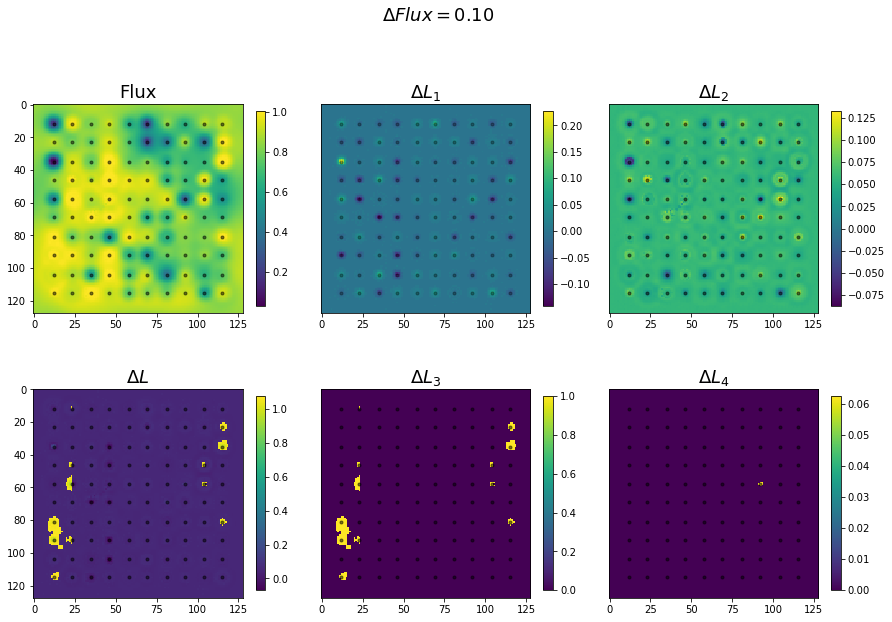

In [145]:
figure(figsize=(15,10))
subplot(231)
imshow(exp(-recon_RSD_tau1[0,...,s]).T)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(232)
imshow(d_f1.T)
title(r'$\Delta L_1$',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.3)
yticks([])

subplot(233)
imshow(d_f2.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_2$',fontsize=18)
yticks([])


subplot(235)
imshow(d_f3.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_3$',fontsize=18)
yticks([])

subplot(236)
imshow(d_f4.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_4$',fontsize=18)
yticks([])

subplot(234)
imshow((d_f1+d_f2+d_f3+d_f4).T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L$',fontsize=18)
subplots_adjust(hspace=0.1,wspace=0.1)
suptitle(r'$\Delta Flux=%.2f$'%dflux,fontsize=18)
show()

In [149]:
dflux = 0.3
d_f5 = zeros([n,n])
d_f6 = zeros([n,n])
d_f7 = zeros([n,n])
d_f8 = zeros([n,n])

t1 = time.time()

for i in range(n):
    for j in range(n):
        flux_d = flux_recon.copy()
        flux_d[0][i,j,s] = flux_d[0][i,j,s]+dflux
        d_f5[i,j],d_f6[i,j],d_f7[i,j],d_f8[i,j] = sess.run([L1,L2,L3,L4],{yy_lya:lya.vals_observed,Rs:[1],flux:flux_d})
        print('\r'+str(time.time()-t1),end=' ')
d_f5-=loss1
d_f6-=loss2
d_f7-=loss3
d_f8-=loss4

437.0577883720398    

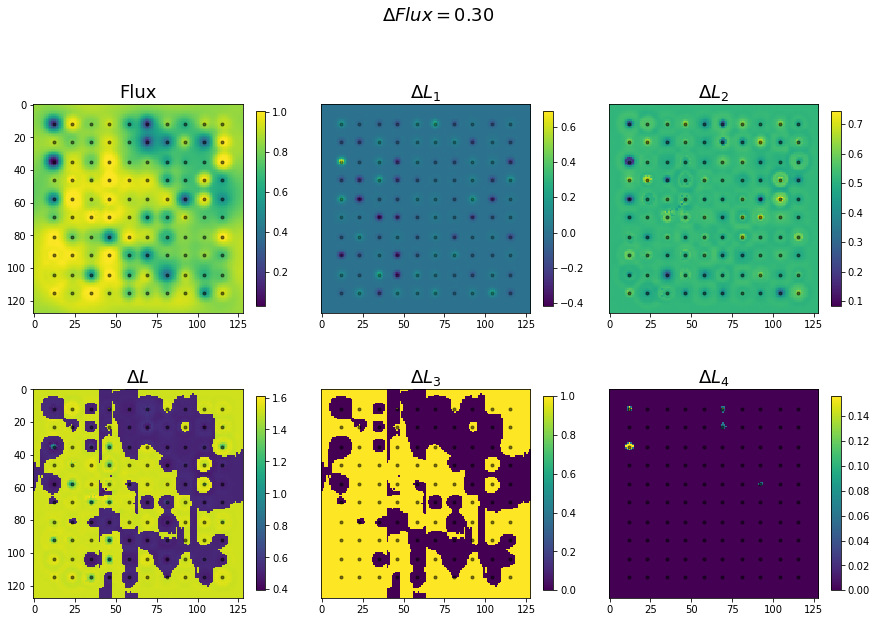

In [152]:
figure(figsize=(15,10))
subplot(231)
imshow(exp(-recon_RSD_tau1[0,...,s]).T)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(232)
imshow(d_f5.T)
title(r'$\Delta L_1$',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.3)
yticks([])

subplot(233)
imshow(d_f6.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_2$',fontsize=18)
yticks([])


subplot(235)
imshow(d_f7.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_3$',fontsize=18)
yticks([])

subplot(236)
imshow(d_f8.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_4$',fontsize=18)
yticks([])

subplot(234)
imshow((d_f5+d_f6+d_f7+d_f8).T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L$',fontsize=18)
subplots_adjust(hspace=0.1,wspace=0.1)
suptitle(r'$\Delta Flux=%.2f$'%dflux,fontsize=18)
show()

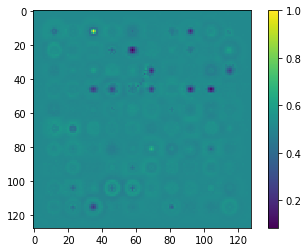

In [158]:
imshow(d_f5+d_f6)
colorbar()

In [155]:
dflux = -0.1
d_f9 = zeros([n,n])
d_f10 = zeros([n,n])
d_f11 = zeros([n,n])
d_f12 = zeros([n,n])

t1 = time.time()

for i in range(n):
    for j in range(n):
        flux_d = flux_recon.copy()
        flux_d[0][i,j,s] = flux_d[0][i,j,s]+dflux
        d_f9[i,j],d_f10[i,j],d_f11[i,j],d_f12[i,j] = sess.run([L1,L2,L3,L4],{yy_lya:lya.vals_observed,Rs:[1],flux:flux_d})
        print('\r'+str(time.time()-t1),end=' ')
d_f9-=loss1
d_f10-=loss2
d_f11-=loss3
d_f12-=loss4

435.53346729278564   

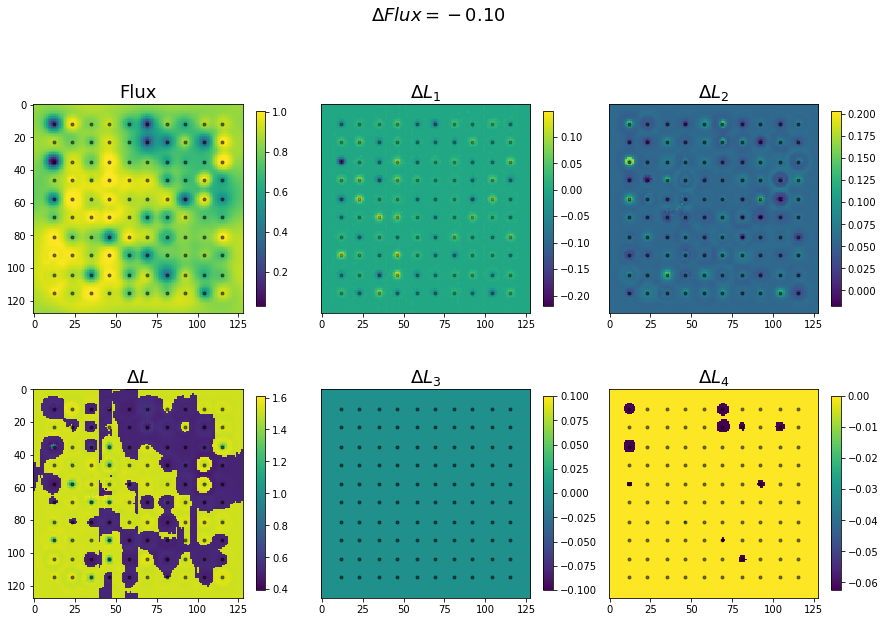

In [156]:
figure(figsize=(15,10))
subplot(231)
imshow(exp(-recon_RSD_tau1[0,...,s]).T)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)

subplot(232)
imshow(d_f9.T)
title(r'$\Delta L_1$',fontsize=18)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.3)
yticks([])

subplot(233)
imshow(d_f10.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_2$',fontsize=18)
yticks([])


subplot(235)
imshow(d_f11.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_3$',fontsize=18)
yticks([])

subplot(236)
imshow(d_f12.T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L_4$',fontsize=18)
yticks([])

subplot(234)
imshow((d_f5+d_f6+d_f7+d_f8).T)
colorbar(shrink=0.75)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],color='k',marker='.',label='skewers',alpha=0.5)
title(r'$\Delta L$',fontsize=18)
subplots_adjust(hspace=0.1,wspace=0.1)
suptitle(r'$\Delta Flux=%.2f$'%dflux,fontsize=18)
show()

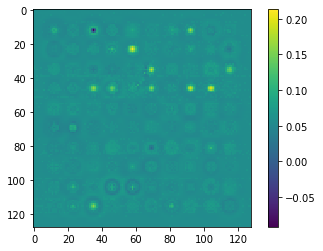

In [157]:
imshow(d_f9+d_f10)
colorbar()

In [45]:
tf.compat.v1.reset_default_graph()
lya = mock_lya
anneal_steps=[2.5,2,1]
# anneal_steps=[2.5,1]
k=[6,36,2.4,0.6]
nc = n
bs = n
gtol=1e-5/512
maxiter=[100,100,100]
kvec = fftk((nc,nc,nc), symmetric=False)
kmesh = sum((np.array(kvec,dtype=object))**2)**0.5
pkmesh = ipklin(kmesh)

RSD_tau=tf.Variable(np.zeros(shape=(1,nc,nc,nc)),dtype='float32',trainable=True)



Rs = tf.placeholder(tf.float64, shape = [1], name='smoothing')

sum_op = reduce_sum_det
Rsm = tf.multiply(Rs, 1)

flux = tf.exp(-RSD_tau)
flux_s = smoothing(flux,Rsm,kmesh,nc)
yy_lya = tf.placeholder(tf.float32, [lya.skewers_fin.shape[0]]) #lya flux
flux_val = flowpm.cic_readout(flux_s,np.array(lya.skewers_fin,dtype=np.float32).reshape(1,-1,3))

L1 = k[0]*chi(flux_val,yy_lya,lya.inverse_covar)
L2 = k[1]*sum_op(tf.square(tf.subtract(flux_s,flux)))
L3 = k[2]*overone(flux)
L4 = k[3]*nodes(flux)

obj_fun = L1+L2
sess = tf.Session()
sess.run(tf.compat.v1.global_variables_initializer())

time_start = time.time()
for nn,r0 in enumerate(anneal_steps):
    opt = ScipyOptimizerInterface(obj_fun, var_list=[RSD_tau], method='L-BFGS-B',
                                       options={'maxiter': maxiter[nn], 'gtol':gtol,'disp': True})

    z = opt.minimize(sess, {yy_lya:lya.vals_observed,Rs:[r0]})
time_end = time.time()
print('Total run time %f'%(time_end-time_start))
recon_RSD_tau2,recon_flux,flux_out = sess.run([RSD_tau,flux_val,flux],{yy_lya:lya.vals_observed,Rs:[1]})
jac2 = opt.result.jac.reshape(n,n,n)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 14462.918945
  Number of iterations: 57
  Number of functions evaluations: 78
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 14353.007812
  Number of iterations: 41
  Number of functions evaluations: 55
INFO:tensorflow:Optimization terminated with:
  Message: b'STOP: TOTAL NO. of ITERATIONS REACHED LIMIT'
  Objective function value: 13186.505859
  Number of iterations: 100
  Number of functions evaluations: 101
Total run time 15.893569


In [46]:
d_f7 = zeros([n,n])
d_f8 = zeros([n,n])

t1 = time.time()

flux_recon = exp(-recon_RSD_tau2)
loss_1,loss_2 = sess.run([L1,L2],{yy_lya:lya.vals_observed,Rs:[1],flux:flux_recon})
for i in range(n):
    for j in range(n):
        flux_d = flux_recon.copy()
        flux_d[0][i,j,0] = flux_d[0][i,j,0]-0.5
        d_f7[i,j],d_f8[i,j] = sess.run([L1,L2],{yy_lya:lya.vals_observed,Rs:[1],flux:flux_d})
        print('\r'+str(time.time()-t1),end=' ')
        
d_f7 = d_f7-loss_1
d_f8 = d_f8-loss_2

16.136332511901855   

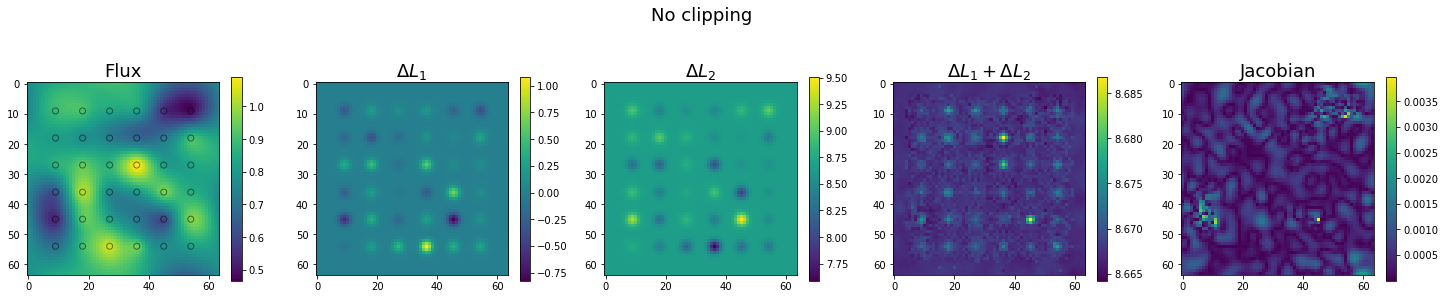

In [47]:
figure(figsize=(25,5))
subplot(151)
imshow(exp(-recon_RSD_tau2[0,...,0]).T)
colorbar(shrink=0.75)
title('Flux',fontsize=18)
plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],label='skewers',alpha=0.5,color='',edgecolors='k',marker='o')

subplot(152)
imshow(d_f7.T)
title(r'$\Delta L_1$',fontsize=18)
colorbar(shrink=0.75)
# plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],label='skewers',alpha=0.5,color='',edgecolors='k',marker='o')

subplot(153)
imshow(d_f8.T)
title(r'$\Delta L_2$',fontsize=18)
colorbar(shrink=0.75)
# plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],label='skewers',alpha=0.5,color='',edgecolors='k',marker='o')

subplot(154)
imshow((d_f7+d_f8).T)
title(r'$\Delta L_1+\Delta L_2$',fontsize=18)
colorbar(shrink=0.75)
# plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],label='skewers',alpha=0.5,color='',edgecolors='k',marker='o')

subplot(155)
imshow(abs(jac2[:,:,0]).T)
colorbar(shrink=0.75)
# plt.scatter(mock_lya.skewers_fin[::n][:,0],mock_lya.skewers_fin[::n][:,1],label='skewers',alpha=0.5,color='',edgecolors='k',marker='o')
title('Jacobian',fontsize=18)

suptitle('No clipping',fontsize=18)
show()